In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

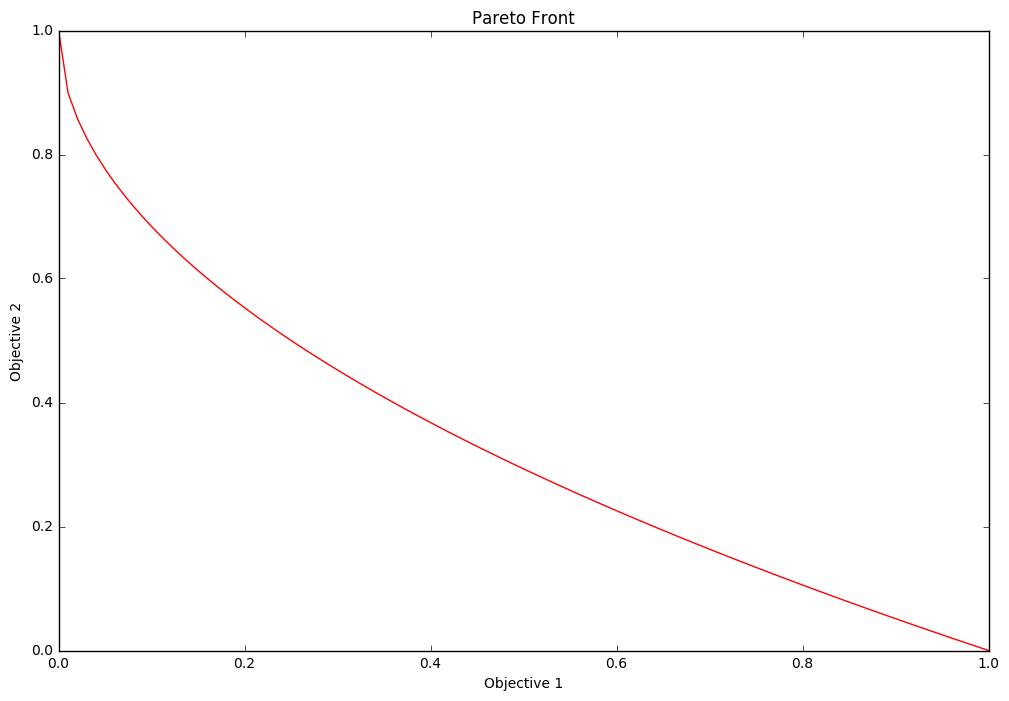

In [2]:
X = np.linspace(0, 1, 100)
Y = 1 - np.sqrt(X)

plt.figure(figsize=(12, 8))
plt.plot(X, Y, 'r-')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.title('Pareto Front')
plt.show()

### Wyznaczanie frontu Pareto algorytmem NSGA-II

In [3]:
import sys

sys.path.append('nsga2/')

from metrics.problems.zdt import ZDT4Metrics
from nsga2.evolution import Evolution
from nsga2.utils import NSGA2Utils
# from nsga2.problems.zdt import ZDT

from nsga2.individual import Individual
from nsga2.problems import Problem
import random
import functools

class ZDT(Problem):

    def __init__(self, zdt_definitions):
        self.zdt_definitions = zdt_definitions
        self.max_objectives = [None, None]
        self.min_objectives = [None, None]
        self.problem_type = None
        self.n = 30

    def __dominates(self, individual2, individual1):
        worse_than_other = self.zdt_definitions.f1(individual1) <= self.zdt_definitions.f1(individual2) and self.zdt_definitions.f2(individual1) <= self.zdt_definitions.f2(individual2)
        better_than_other = self.zdt_definitions.f1(individual1) < self.zdt_definitions.f1(individual2) or self.zdt_definitions.f2(individual1) < self.zdt_definitions.f2(individual2)
        return worse_than_other and better_than_other

    def generateIndividual(self):
        individual = Individual()
        individual.features = [random.random()]
        for i in range(self.n - 1):
            individual.features.append((random.random() - .5) * 10)
        individual.dominates = functools.partial(self.__dominates, individual1=individual)
        self.calculate_objectives(individual)
        return individual

    def calculate_objectives(self, individual):
        individual.objectives = []
        individual.objectives.append(self.zdt_definitions.f1(individual))
        individual.objectives.append(self.zdt_definitions.f2(individual))
        for i in range(2):
            if self.min_objectives[i] is None or individual.objectives[i] < self.min_objectives[i]:
                self.min_objectives[i] = individual.objectives[i]
            if self.max_objectives[i] is None or individual.objectives[i] > self.max_objectives[i]:
                self.max_objectives[i] = individual.objectives[i]

from nsga2.problems.zdt.zdt4_definitions import ZDT4Definitions

def print_statistics(population, iteration):
    PF = population.fronts[0]
    metrics = ZDT4Metrics()
    print("Iteration %03d: HV = %0.2f, HVR = %0.2f" % (iteration, metrics.HV(PF), metrics.HVR(PF)))

statistics = []
def log_statistics(population, iteration):
    ranks = [individual.rank for individual in population]
    crowding_distances = [individual.crowding_distance for individual in population]
    objectives = [individual.objectives for individual in population]

    pareto_front = population.fronts[0]
    metrics = ZDT4Metrics()
    hv = metrics.HV(pareto_front)
    hvr = metrics.HVR(pareto_front)

    statistics.append((hv, hvr, ranks, crowding_distances, objectives))

In [4]:
def plot_PF(results):
    PF = np.array([i.objectives for i in results])

    plt.figure(figsize=(12, 8))
    plt.plot(PF[:, 0], PF[:, 1], 'ro')
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.title('Pareto Front')
    plt.show()

Iteration 000: HV = 1129.57, HVR = 9.36
Iteration 001: HV = 520.96, HVR = 4.32
Iteration 002: HV = 520.96, HVR = 4.32
Iteration 003: HV = 520.96, HVR = 4.32
Iteration 004: HV = 520.96, HVR = 4.32
Iteration 005: HV = 491.67, HVR = 4.07
Iteration 006: HV = 491.67, HVR = 4.07
Iteration 007: HV = 491.67, HVR = 4.07
Iteration 008: HV = 491.67, HVR = 4.07
Iteration 009: HV = 491.67, HVR = 4.07
Iteration 010: HV = 491.67, HVR = 4.07
Iteration 011: HV = 491.67, HVR = 4.07
Iteration 012: HV = 491.67, HVR = 4.07
Iteration 013: HV = 486.98, HVR = 4.04
Iteration 014: HV = 486.98, HVR = 4.04
Iteration 015: HV = 486.98, HVR = 4.04
Iteration 016: HV = 486.98, HVR = 4.04
Iteration 017: HV = 486.98, HVR = 4.04
Iteration 018: HV = 404.44, HVR = 3.35
Iteration 019: HV = 404.44, HVR = 3.35
Iteration 020: HV = 404.44, HVR = 3.35
Iteration 021: HV = 404.44, HVR = 3.35
Iteration 022: HV = 404.44, HVR = 3.35
Iteration 023: HV = 383.81, HVR = 3.18
Iteration 024: HV = 383.81, HVR = 3.18
Iteration 025: HV = 383.

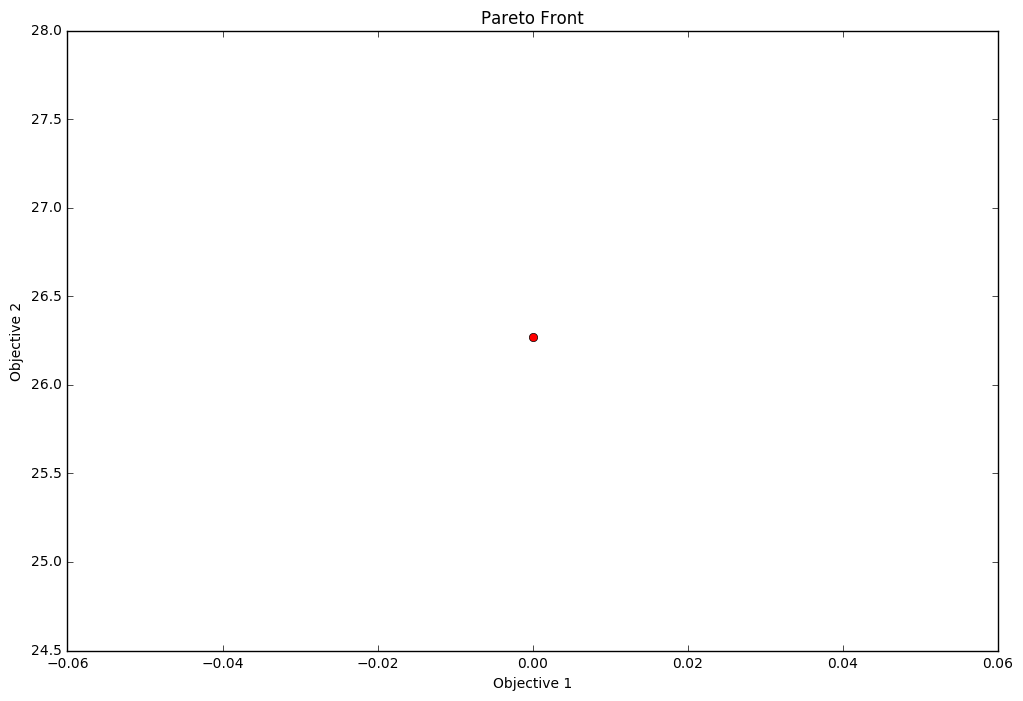

CPU times: user 24min 36s, sys: 14.6 s, total: 24min 51s
Wall time: 24min 19s


In [5]:
%%time

pop_size = 200

solver = Evolution(ZDT(ZDT4Definitions()), 200, pop_size)
solver.utils = NSGA2Utils(ZDT(ZDT4Definitions()), pop_size, mutation_strength=.5, num_of_genes_to_mutate=20)
solver.register_on_new_generation(print_statistics)
solver.register_on_new_generation(log_statistics)

results = solver.evolve()

plot_PF(results)

### Wykres HV i HVR

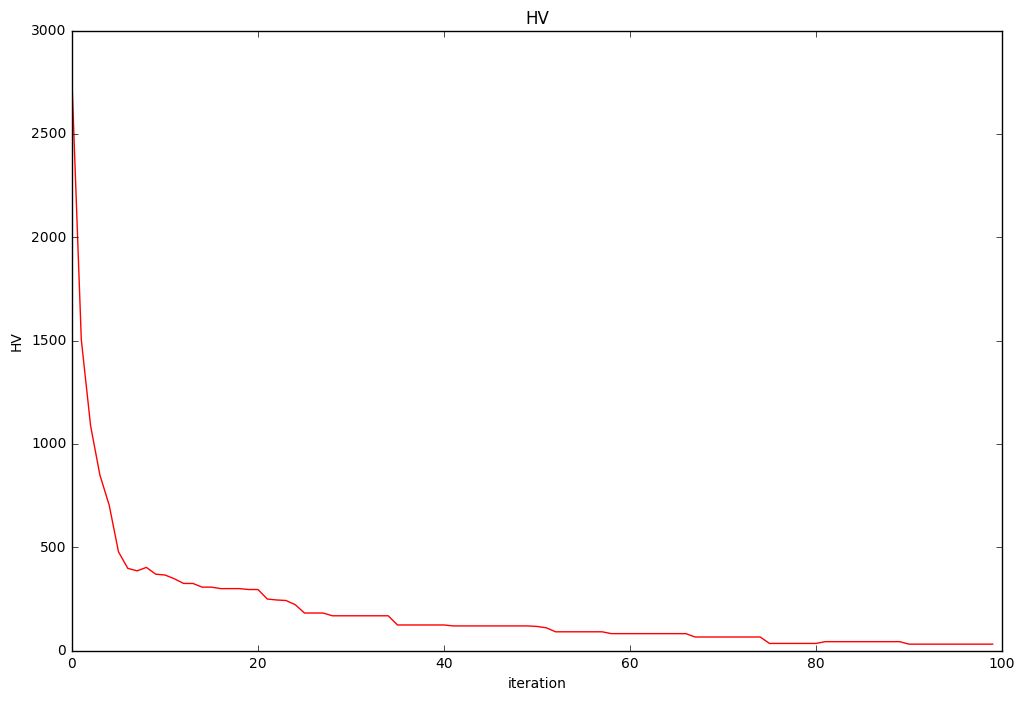

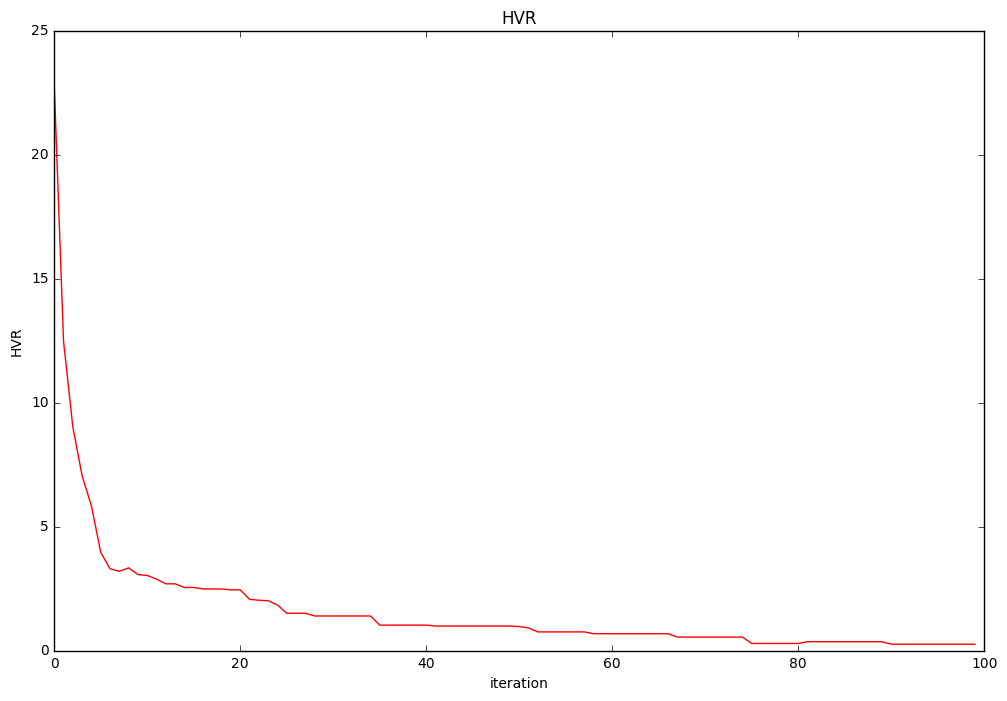

In [18]:
HV = np.array([statistics[i][0] for i in xrange(len(statistics))])
HVR = np.array([statistics[i][1] for i in xrange(len(statistics))])

plt.figure(figsize=(12, 8))
plt.plot(HV, 'r-')
plt.xlabel('iteration')
plt.ylabel('HV')
plt.title('HV')
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(HVR, 'r-')
plt.xlabel('iteration')
plt.ylabel('HVR')
plt.title('HVR')
plt.show()

### Wykres przykładowej populacji (ze wskazanej iteracji)

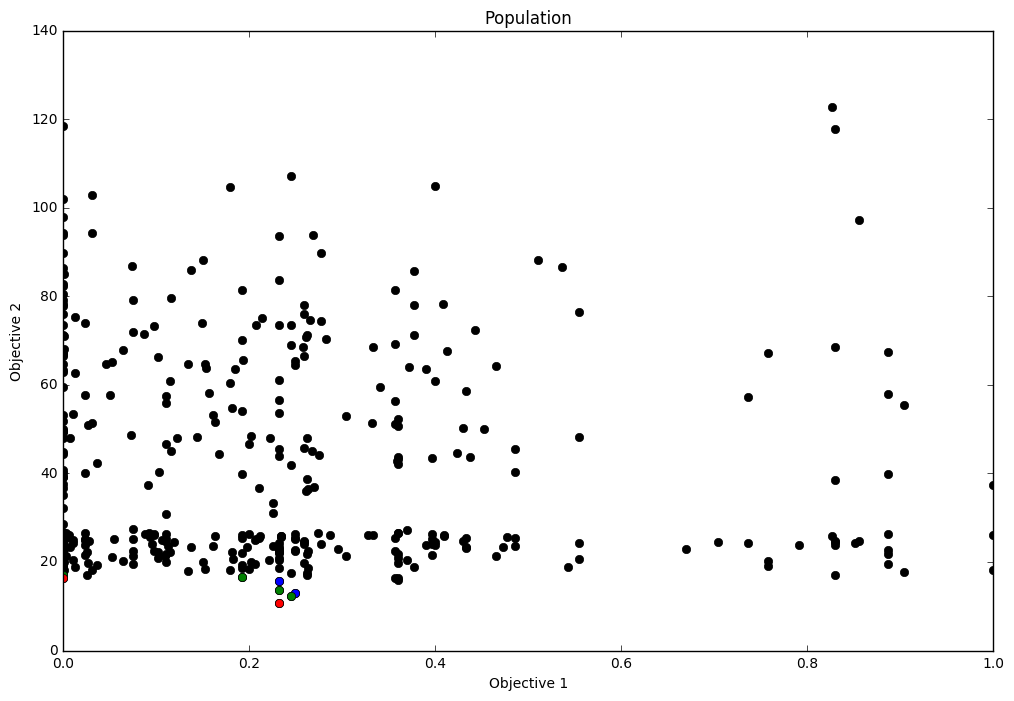

In [19]:
iteration = len(statistics)-1

ranks = np.array(statistics[iteration][2])
objectives = np.array(statistics[iteration][4])

PF0 = (ranks == 0)
PF1 = (ranks == 1)
PF2 = (ranks == 2)

plt.figure(figsize=(12, 8))
plt.plot(objectives[:, 0], objectives[:, 1], 'ko')
plt.plot(objectives[PF2, 0], objectives[PF2, 1], 'bo')
plt.plot(objectives[PF1, 0], objectives[PF1, 1], 'go')
plt.plot(objectives[PF0, 0], objectives[PF0, 1], 'ro')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.title('Population')
plt.show()